In [1]:
from characters_real_names import *

import re
import spacy
from spacy.tokens import Span

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

from community import community_louvain as louvain
from netwulf import visualize

nlp = spacy.load("en_core_web_sm")

# Used to get the gender and distinct people with same family noun. 

def get_person_title(span):
    if span.label_ == "PERSON" and span.start != 0:
        prev_token = span.doc[span.start - 1]
        if prev_token.text in ("Mr", "Mr.", "Mrs", "Mrs."):
            return prev_token.text + " "
    return ""

Span.set_extension("person_title", getter=get_person_title, force=True)

book = open("../Homework 1/Harry Potter and the Sorcerer.txt").read()

book_chapters = re.split(r'CHAPTER [\w+]+', book, flags=re.IGNORECASE)[1:]
book_chapters[-1] = book_chapters[-1].split("THE END")[0]


In [2]:
docs = nlp(''.join(book_chapters))
all_sentences = [sent.text.strip() for sent in docs.sents]

In [20]:
from tqdm import tqdm
all_characters_per_sentence = list()
all_sentences_modified = list()

# 7275 iterations
for i,sentence in tqdm(enumerate(all_sentences)):
    doc = nlp(sentence)
    entities = [dict(title=ent._.person_title,name=ent.text,position=(ent.start,ent.end)) for ent in doc.ents if ent.label_ == "PERSON"]
    all_characters_per_sentence.append(set())
    all_sentences_modified.append(sentence)

    for entity in entities:
        full_name = (entity.get('title') + entity.get('name')).strip()
        full_name_underscore = '_'.join(full_name.split(" "))
        
        if full_name in all_real_names.keys():
            all_characters_per_sentence[i].add(full_name)
            continue
        elif full_name_underscore in all_real_names.keys():
            all_sentences_modified[i] = re.sub(full_name, full_name_underscore, all_sentences_modified[i])
            all_characters_per_sentence[i].add(full_name_underscore)
            continue
        # Otherwise iterate on all names.
        for real,check in all_real_names.items():
            if full_name in check: 
                real_underscore = "_".join(real.split(" "))
                all_sentences_modified[i] = re.sub(full_name, real_underscore, all_sentences_modified[i])
                all_characters_per_sentence[i].add(real_underscore)


7275it [00:53, 136.19it/s]


In [26]:
all_characters_global = set()
for characters in all_characters_per_sentence:
    for character in characters:
        all_characters_global.add(character)
len(all_characters_global)

In [31]:
# Graph filling by sentence
graph = nx.Graph()

for characters in all_characters_per_sentence:
    graph.add_nodes_from(characters)
    if len(characters) < 2 : continue
    unique = list(characters)
    for idx in range(len(unique)-1):
        edge = graph.get_edge_data(unique[idx], unique[idx-1])
        if edge is not None : graph[unique[idx]][unique[idx-1]]['weight'] += 1
        else : graph.add_edge(unique[idx], unique[idx-1], weight=1)



In [32]:
# ---
# Louvain Algorithm
# https://github.com/taynaud/python-louvain

# Use mean partition of 100 partitions to smooth
boot_partitions = {}
for _ in tqdm(range(100)): 
    part = louvain.best_partition(graph)
    for k,v in part.items():
        if k in boot_partitions: boot_partitions[k].append(v)
        else: boot_partitions[k] = [v]

partition = {}
for k,v in boot_partitions.items(): partition[k] = round(sum(v) / len(v))

100%|██████████| 100/100 [00:00<00:00, 236.47it/s]


In [35]:
partition
partition_clean = {}
for v,k in partition.items():
    if k not in partition_clean:
        partition_clean[k] = [v]
    else: partition_clean[k].append(v)
partition_clean

partition_sorted = dict(sorted(partition.items()))

In [37]:
from gensim.parsing.preprocessing import preprocess_string

from string import punctuation
from gensim.parsing.preprocessing import strip_tags     
from gensim.parsing.preprocessing import strip_short      
from gensim.parsing.preprocessing import strip_multiple_whitespaces
from gensim.parsing.preprocessing import strip_non_alphanum

CUSTOM_FILTERS = [lambda x: strip_short(x.lower(), 1), strip_multiple_whitespaces, strip_tags, strip_non_alphanum]

all_sentences_preprocessed = []
punctuation_to_remove = punctuation.replace("_", "")
for sent in tqdm(all_sentences_modified):
    sent = sent.translate(str.maketrans('', '', punctuation_to_remove))
    parsed_line = preprocess_string(sent, CUSTOM_FILTERS)
    all_sentences_preprocessed.append(parsed_line)

100%|██████████| 7275/7275 [00:00<00:00, 30769.94it/s]


In [38]:
import gensim

# DEFINE MODEL
model = gensim.models.Word2Vec(size=100, window = 6,
                               min_count=1, alpha = 1)

# BUILD VOCABULARY
model.build_vocab(all_sentences_preprocessed)

# AND TRAIN THE MODEL
iterations = range(10)
for i in tqdm(iterations):
    model.train(all_sentences_preprocessed, total_examples=model.corpus_count, compute_loss = True, 
                epochs = 100)
    
# GET THE VOCABULARY FROM THE MODEL
vocabulary = list(model.wv.vocab)
print(f"Vocabulary size :: {len(vocabulary)}")

# GET THE WORD EMBEDDING VECTORS
embedding_vectors = model[model.wv.vocab]

100%|██████████| 10/10 [00:51<00:00,  5.12s/it]Vocabulary size :: 6100



In [39]:
person_set_processed = [s for s in all_real_names if s.lower() in vocabulary]
person_set_vocab = [s.lower() for s in person_set_processed]
embedding_vectors_caracters=model[person_set_vocab]
#person_set_vocab

In [40]:
person_set_vocab

['hannah_abbott',
 'irma_pince',
 'poppy_pomfrey',
 'james_potter',
 'lily_potter',
 'harry_potter',
 'quirinus_quirrell',
 'gregory_goyle',
 'hermione_granger',
 'sirius_black',
 'rubeus_hagrid',
 'helga_hufflepuff',
 'angelina_johnson',
 'lee_jordan',
 'neville_longbottom',
 'susan_bones',
 'draco_malfoy',
 'minerva_mcgonagall',
 'garrick_ollivander',
 'malfoys_family',
 'auntie_marge',
 'piers_polkiss',
 'salazar_slytherin',
 'severus_snape',
 'bill_weasley',
 'charlie_weasley',
 'fred_weasley',
 'george_weasley',
 'ginny_weasley',
 'molly_weasley',
 'percy_weasley',
 'weasley_family',
 'ron_weasley',
 'oliver_wood',
 'nicholas_de_mimsy',
 'norbert',
 'vincent_crabbe',
 'dedalus_diggle',
 'katie_bell',
 'dudley_dursley',
 'petunia_dursley',
 'vernon_dursley',
 'dursleys_family',
 'arabella_figg',
 'argus_filch',
 'seamus_finnigan',
 'nicolas_flamel',
 'filius_flitwick',
 'tom_riddle',
 'alicia_spinnet',
 'dean_thomas',
 'adalbert_waffling',
 'bane',
 'firenze',
 'fluffy',
 'griphook

In [13]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# TRANSFORM THE EMBEDDING USING T-SNE INTO 2D
V_tranform = TSNE(n_components=2).fit_transform(embedding_vectors_caracters)

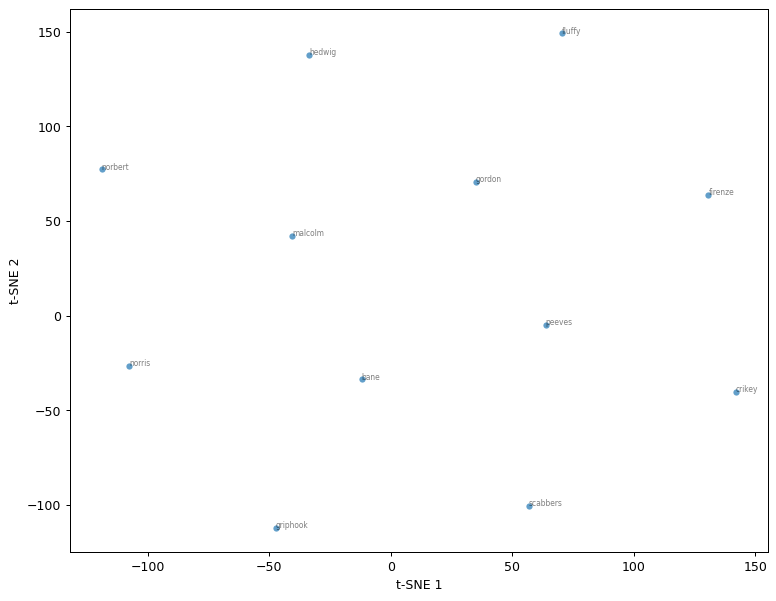

In [14]:
# PLOT THE PROJECTION
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (10,8), dpi = 90)
plt.scatter(*zip(*V_tranform), marker='.', s=100, lw=0, alpha=0.7, 
                 edgecolor='k')
for i, (x,y) in enumerate(V_tranform):
    plt.text(x,y, person_set_vocab_sorted[i], 
            fontsize = 6, alpha = 0.5)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()

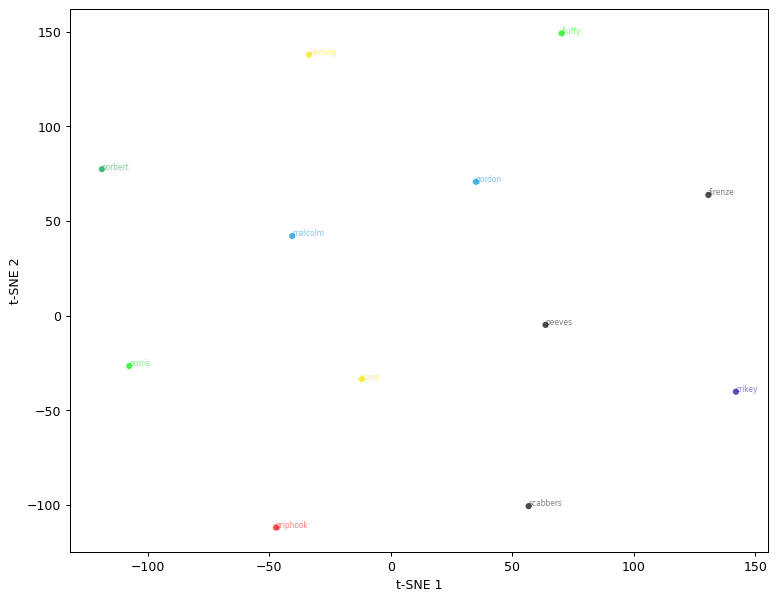

In [42]:
import nltk
import matplotlib.cm as cm
import numpy as np
# THIS IS THE IMPLEMENTATION OF THE KMEANS WITH COSINE DISTANCE
from nltk.cluster import KMeansClusterer

# desired number of clusters to find
NUM_CLUSTERS=7

# Sparial clustering with k-means

kclusterer = KMeansClusterer(NUM_CLUSTERS, distance= nltk.cluster.util.cosine_distance, repeats=10)

# be careful to supply the original vectors to the algorithm!
assigned_clusters = kclusterer.cluster(embedding_vectors_caracters, assign_clusters=True)

# DEFINE COLORS OF CLUSTERS 
colors = cm.nipy_spectral(np.array(assigned_clusters).astype(float) / NUM_CLUSTERS)

# PLOT THE RESULTS
fig = plt.figure(figsize = (10,8), dpi = 90)
plt.scatter(*zip(*V_tranform), marker='.', s=100, lw=0, alpha=0.7, c=colors,
                 edgecolor='k')

for i, (x,y) in enumerate(V_tranform):
    plt.text(x,y, person_set_vocab_sorted[i], color = colors[i], 
                fontsize = 6, alpha = 0.5)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()

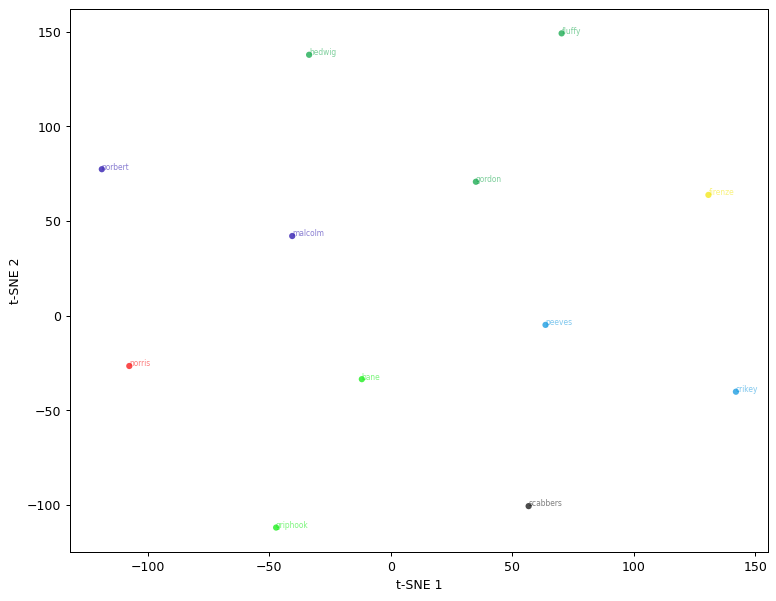

In [16]:
# THIS IS THE IMPLEMENTATION OF THE KMEANS WITH EUCLIDEAN DISTANCE
from sklearn.cluster import KMeans

# desired number of clusters to find
NUM_CLUSTERS=7

# Sparial clustering with k-means

kclusterer_sklearn = KMeans(n_clusters = NUM_CLUSTERS)

# be careful to supply the projected vectors (2D) to the algorithm!
assigned_clusters = kclusterer_sklearn.fit_predict(V_tranform)

# DEFINE COLORS OF CLUSTERS 
colors = cm.nipy_spectral(np.array(assigned_clusters).astype(float) / NUM_CLUSTERS)

# PLOT THE RESULTS
fig = plt.figure(figsize = (10,8), dpi = 90)
plt.scatter(*zip(*V_tranform), marker='.', s=100, lw=0, alpha=0.7, c=colors,
                 edgecolor='k')

for i, (x,y) in enumerate(V_tranform):
    plt.text(x,y, person_set_vocab_sorted[i], color = colors[i], 
                fontsize = 6, alpha = 0.5)

plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()

In [17]:
for i in range(len(person_set_vocab)):
    print(person_set_vocab_sorted[i], "   ",list(partition_sorted.keys())[i])

print(list(partition_sorted.keys())[61])

norbert 1
bane 4
firenze 5
fluffy 3
griphook 4
hedwig 3
norris 6
peeves 2
scabbers 0
crikey 2
gordon 3
